



<div class="row">
  <div class="column">
    <img src="../../../img/Atr_logo.png" width="250">
  </div>
</div>





# Propeller ADL Model


Propeller performances to evaluate propeller thrust from a given power was evaluated using the actuator disk theory.


In [1]:
#Run this cell to import the needed modules/packages  N.B: Double click on the left to expand the window
'''
FOR THE EXTENSION OF CELL COLLAPSING:
pip install nbextension-cellfolding
jupyter nbextension install --py cellfolding --user
jupyter nbextension enable --py cellfolding --user 
'''
from fastoad.utils.physics import Atmosphere
from scipy import constants

import numpy as np
import pandas as pd
import os.path as pth
import matplotlib.pyplot as plt
from fastoad.io import VariableIO 
from fastoad.utils.postprocessing import VariableViewer

from fastoad.utils.physics import Atmosphere
from openmdao.core.explicitcomponent import ExplicitComponent
import pickle
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import fsolve

Unable to import mpi4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.


## Propeller Sizing

In [6]:
#inputs
disk_loading=2244/(constants.pi*(3.93/2)**2) #kW/m2 #the lower the higher eta but also the mass (higher d)

max_power=2244 #kW

#evaluate propeller diameter
d=(4*max_power/(constants.pi*disk_loading))**0.5
print(d)
#evaluate max rotational speed
altitude =0
mach=0
atmosphere = Atmosphere(altitude, altitude_in_feet=False)
a = atmosphere.speed_of_sound
omega= 2*a/d*((0.7**2-mach**2)**0.5) #rad/s
rpm_max=60/(2*constants.pi)*omega
print(rpm_max)

3.93
1157.611339514273


## Propeller Performance

Power to thrust

In [27]:
#########INPUTS##########
#hybrid: [468.87669819] [0.26441598] [2139.28082396] [2139.28082396] [15461.18770688] [15461.18770688] [537.71679071]
shp_prop=1276.#2000*0.99 #hp
altitude =10000.*constants.foot #m
mach=0.3
atmosphere = Atmosphere(altitude, altitude_in_feet=False)
a = atmosphere.speed_of_sound
V_TAS = mach*a #m/s
V_TAS= 209*constants.knot


In [33]:
#########evaluate thrust from given power########

rpm=0.83*rpm_max
rho= atmosphere.density
k_thrust=0.895
J=V_TAS/(rpm*d)
#d=3.882186246764011
d = 4.14528

def P_to_T(thrust,shp_prop,V_TAS,rho,d):
    return (thrust*V_TAS/(shp_prop* constants.hp))-2/(1+(1+(thrust/(0.5 * rho * constants.pi/4 * d**2 * V_TAS**2)))**0.5)

thrust = k_thrust*fsolve(P_to_T, 1,args=(shp_prop,V_TAS,rho,d))[0]
eta = thrust * V_TAS/(shp_prop* constants.hp) #N 

print(eta,thrust/constants.lbf)

print(1729*constants.lbf,1770*constants.lbf)

0.8692895908756578 1729.4501093898905
7690.975172785404 7873.352259011084


Thrust to Power  

In [16]:
#########INPUTS##########
thrust=1865*constants.lbf #N
altitude =25000*constants.foot #m
mach=0.2
atmosphere = Atmosphere(altitude, altitude_in_feet=False)
a = atmosphere.speed_of_sound
V_TAS = mach*a 
V_TAS= 280*constants.knot
print(thrust,altitude,V_TAS)

8295.933312460831 7619.999999999999 144.04444444444445


In [17]:
#inputs
rpm=0.83*rpm_max
rho= atmosphere.density
k_thrust=1
J=V_TAS/(rpm*d)
print(J)

#evaluate required power from given thrust

eta= 2/(1+(1+(thrust/(0.5 * rho * constants.pi/4 * d**2 * V_TAS**2)))**0.5)
shp_prop = thrust*V_TAS/eta /constants.hp

print(eta,shp_prop)



0.03616610819400697
0.9743802438285968 1644.6338591503836


## 4. Validation

The reference data is provided in the document "H568F_NP82.txt"

In [7]:
#REFERENCE DATA

prop_file_name = "C:/Users/LA202059/Desktop/RHEA/rhea/resources/propeller/H568F/Experimental_data/H568F_NP82.txt"
data = pd.read_csv(prop_file_name, delimiter='	')


In [8]:
data['ETA_ADT']=''
for row in data.index :
    V_TAS=data.loc[row].TAS *constants.knot
    shp_prop=data.loc[row].SHP
    altitude=data.loc[row].Altitude
    
    

    atmosphere = Atmosphere(altitude, altitude_in_feet=True)
    rho= atmosphere.density
    k_thrust=0.895


    #evaluate thrust from given power

    def P_to_T(thrust,shp_prop,V_TAS,rho,d):
        return (thrust*V_TAS/(shp_prop* constants.hp))-2/(1+(1+(thrust/(0.5 * rho * constants.pi/4 * d**2 * V_TAS**2)))**0.5)

    thrust = k_thrust*fsolve(P_to_T, 1,args=(shp_prop,V_TAS,rho,d))[0]
    eta = thrust * V_TAS/(shp_prop* constants.hp) #N
    
    
    data.loc[row,'ETA_ADT']=eta

Mean squared error 0.0004185658326078754
Mean absolute error 0.012093054902541383


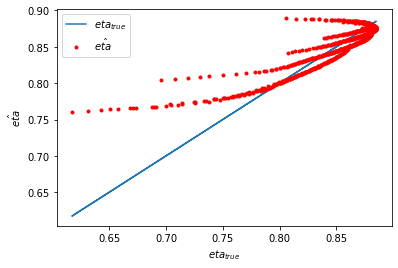

In [9]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

data=data.loc[data.TAS>100]
data=data.loc[data.SHP<2750]
data=data.loc[data.TAS<350]

ytest= data.ETA.values
y= data.ETA_ADT.values

fig = plt.figure()
plt.plot(ytest, ytest, '-', label='$eta_{true}$')
plt.plot(ytest, y, 'r.', label='$\hat{eta}$')
   
plt.xlabel('$eta_{true}$')
plt.ylabel('$\hat{eta}$')

plt.legend(loc='upper left')
print('Mean squared error', mean_squared_error(ytest,y)) 
print('Mean absolute error', mean_absolute_error(ytest,y)) 